# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

gainArray = []
lossArray = []

predictedGain = []
predictedLoss = []
expectedGain  = []
expectedLoss  = []

originalDataSet = pd.read_csv('dataset.txt', sep=',',header = None)
#originalDataSet = pd.read_csv('reduced_dataset', sep = ',',header = None)
scaler = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return (invertNorm(value1) - invertNorm(value2))**2

# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else :
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            #print("Gain: ", invertNorm(predicted[0]), round(invertNorm(expected[0]), 14))
            #print("Loss: ", invertNorm(predicted[1]), round(invertNorm(expected[1]), 14))
            gainErrors.append(getError(predicted[0], expected[0]))
            lossErrors.append(getError(predicted[1], expected[1]))
            
            predictedGain.append(invertNorm(predicted[0]))
            expectedGain.append(invertNorm(expected[0]))
            predictedLoss.append(invertNorm(predicted[1]))
            expectedLoss.append(invertNorm(expected[1]))

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy): 
    global gainArray, lossArray
    
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray = gainErrors
    lossArray = lossErrors

# Plotting functions

In [4]:
def plotBoxplot():
    fig, axis = plt.subplots(figsize = (10, 5))
    gainData  = gainArray
    lossData  = lossArray
    
    aux = [gainData, lossData]

    axis.boxplot(aux)
    axis.set_title("KNN Test Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Loss"], fontsize = 14)
    axis.set_ylabel("MAE", fontsize = 14)

    plt.show()

In [5]:
def plotExpectedXPredictedGain():
    fig, axis = plt.subplots(figsize = (10, 5))
    predictedData = predictedGain
    expectedData  = expectedGain

    axis.scatter(x = expectedData, y = predictedData, c = 'b')
    axis.plot( [min(expectedData), max(expectedData)], [min(predictedData), max(predictedData)], 'k')
    
    axis.set_title("KNN Regression - Gain", fontsize = 16)
    axis.set_xlabel("Predicted Values", fontsize = 14)
    axis.set_ylabel("True Values", fontsize = 14)

    plt.show()

In [6]:
def plotExpectedXPredictedLoss():
    fig, axis = plt.subplots(figsize = (10, 5))
    predictedData = predictedLoss
    expectedData  = expectedLoss

    axis.scatter(x = expectedData, y = predictedData, c = 'r')
    axis.plot( [min(expectedData), max(expectedData)], [min(predictedData), max(predictedData)], 'k')
    
    axis.set_title("KNN Regression - Loss", fontsize = 16)
    axis.set_xlabel("Predicted Values", fontsize = 14)
    axis.set_ylabel("True Values", fontsize = 14)

    plt.show()

# Putting all together

In [7]:
gainArray = []
lossArray = []
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)

[ 1.44  9.    0.16 ...  5.76 11.56  2.56] => 10.54 (+/- 24.90)
[0.64 7.84 0.36 ... 1.   1.   1.  ] => 6.34 (+/- 37.85)


# Plottin error boxplots

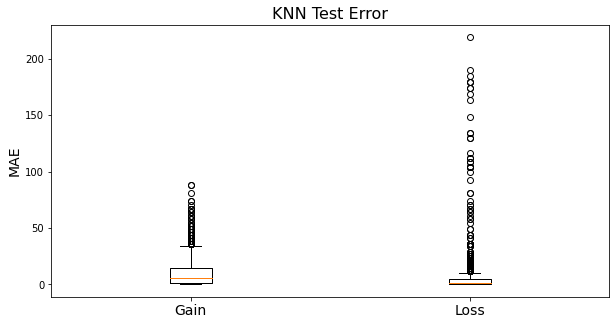

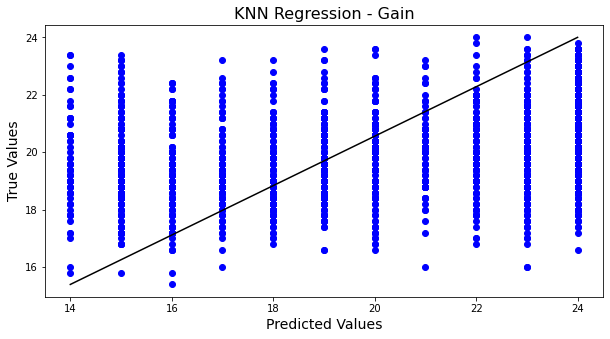

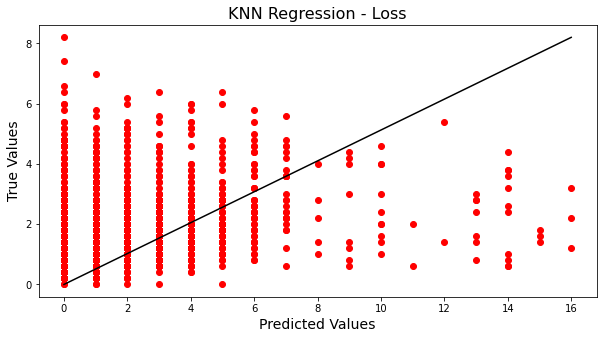

In [8]:
plotBoxplot()
plotExpectedXPredictedGain()
plotExpectedXPredictedLoss()
    